# Telco Customer Churn

Customer churn poses a significant challenge across various industries. It occurs when customers decide to discontinue their purchases of products or services from an organization, terminating their association. This phenomenon is a crucial metric for all businesses, as the loss of customers necessitates acquiring new ones to fill the gap. Acquiring new customers typically incurs a cost nearly 10 times higher than retaining existing ones. Consequently, customer churn can impede the growth of an organization. To mitigate this, implementing a retention strategy is essential to prevent an escalation in customer churn rates.

Our objective is to discern patterns among churned customers and explore the potential of Machine Learning to successfully identify and forestall churn.

### *Libraries*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import scipy.stats.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import shapiro, boxcox

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            roc_auc_score,classification_report,precision_recall_curve,confusion_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, \
                                StratifiedKFold,cross_validate,GridSearchCV

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from lightgbm import LGBMClassifier

plt.style.use('ggplot')
%matplotlib inline

#### Loading the Data

In [2]:
Churn_Df = pd.read_csv('./Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
Churn_Df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
Churn_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Cleansing

- Before we proceed with the next steps, we need first to clean our data
- Our target variable is ***Churn***
- As we see, the values in this column are in **object** format, so we will convert it to numeric

In [4]:
Churn_Df['Churn'] = Churn_Df['Churn'].apply(lambda x: 0 if x.strip().lower() == 'no' else 1)

- We also see that the Total Charges column is not loaded as a number, so we proceed to convert it as well

In [5]:
# Convert TotalCharges to numeric
Churn_Df.TotalCharges = pd.to_numeric(Churn_Df.TotalCharges, errors='coerce')

#### Check for Na values

In [6]:
Churn_Df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
Churn_Df.loc[Churn_Df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


- These 11 customers appear to be newcomers who haven't completed their first month (`tenure = 0`).
- Consequently, their future behavior is unknown, as they are yet to complete their initial month.
- Due to the uncertainty about their future actions and considering their small number, we've decided to remove these records.

In [8]:
Churn_Df.dropna(inplace=True)

## Data Exploration

- This section involves a visual analysis of the data.
- Our focus is on understanding the relationships between various features and our target variable.
- The aim is to identify trends, patterns, and shared characteristics among customers to uncover meaningful insights.

### *Target Variable Distribution*

<Axes: xlabel='Churn', ylabel='count'>

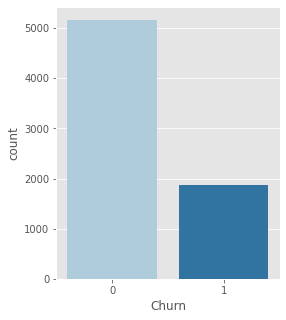

In [9]:
plt.figure(figsize = (4,5))

sns.countplot(Churn_Df['Churn'], palette = 'Paired')

- The dataset is imbalanced 
- There will be a bias, favoring Non-Churn Customers

### *Categorical Features*

In [10]:
def Multi_Boxplot(rows: int, columns: int, t: str, vrbs: list, df: pd.core.frame.DataFrame):
    """
    Generates a multi-boxplot for exploring relationships between categorical variables.

    Parameters:
    - rows (int): Number of rows in the subplot grid.
    - columns (int): Number of columns in the subplot grid.
    - t (str): Target variable for hue in countplot.
    - vrbs (list): List of categorical variables to visualize.
    - df (pd.core.frame.DataFrame): DataFrame containing the data.

    Returns:
    - plt.show(): Displays the multi-boxplot.
    """

    # Set the size of the entire subplot grid
    plt.figure(figsize=(17, 30))

    # Loop through each variable for visualization
    for i, j in enumerate(vrbs):
        # Create subplots
        plt.subplot(rows, columns, i + 1)

        # Generate countplot for the current variable
        sns.countplot(data=df, x=j, hue=t, palette='Paired')

        # Set title and remove x-axis label for better visualization
        plt.title(j)
        plt.xlabel('')

        # Rotate x-axis labels for better readability (specifically for 'PaymentMethod')
        if vrbs[i] == 'PaymentMethod':
            plt.xticks(rotation=45)

    # Display the multi-boxplot
    return plt.show()

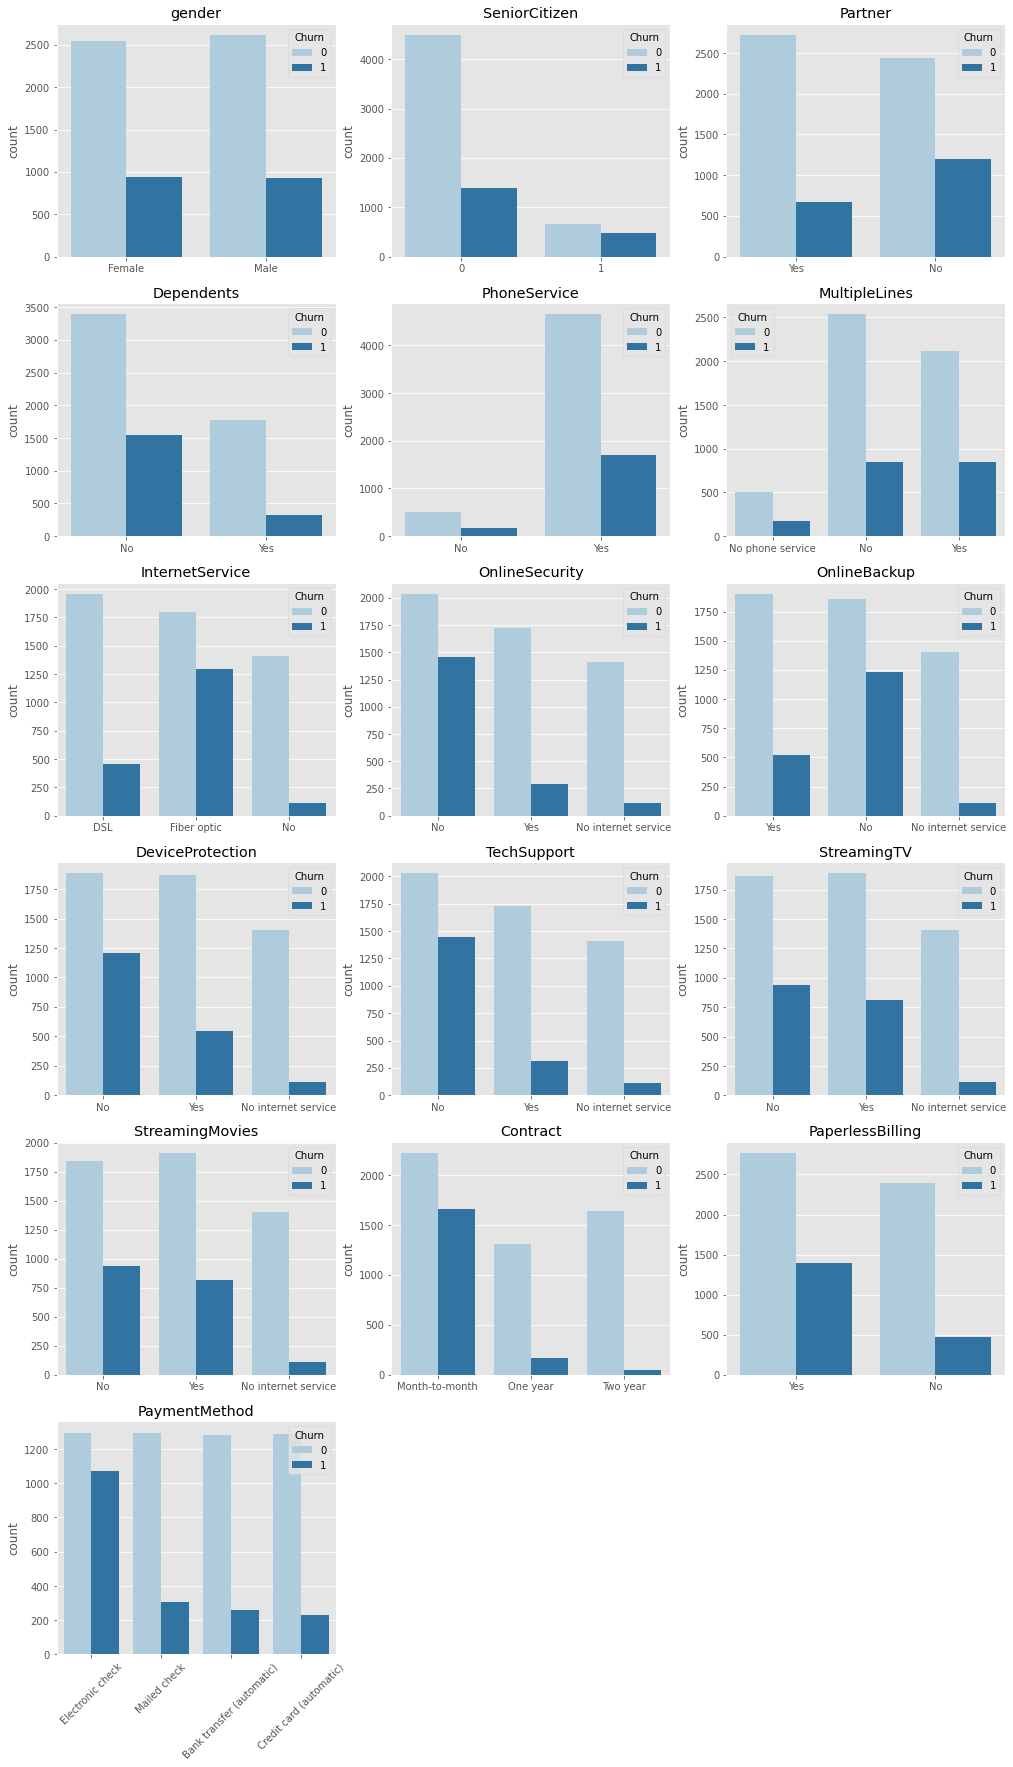

In [11]:
_ = Multi_Boxplot(6,3,'Churn'
              ,[col for col in Churn_Df.columns if col not in 
                ['customerID', 'Churn', 'MonthlyCharges', 'TotalCharges', 'tenure']], Churn_Df)

**Findings**

* Churn seems to be the same for both Genders
* The number of customers categorized as Seniors is low
* Churn is higher for those who have no partner and no dependants
* Streaming TV and Movies have almost identical distributions
* Fiber Optic is the Internet Service of choice, also with a high count of Churn
* Online Security and Backup, Device Security and Tech Support lead to lower churn 
* Churn is high for customers with Month-to-Month Contract

### *Numerical Features*

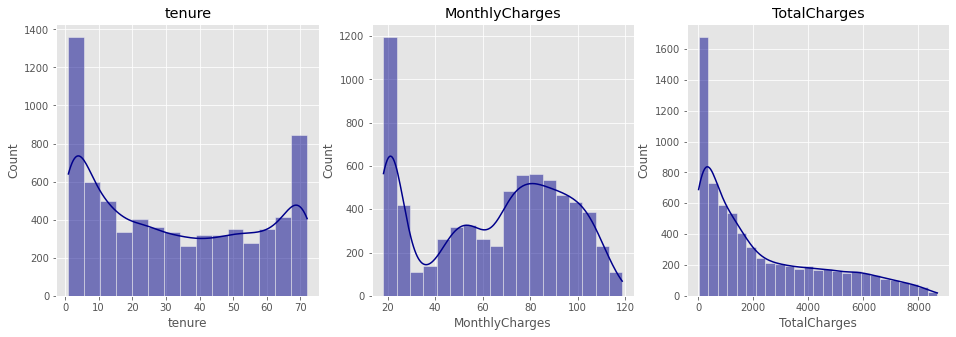

In [12]:
cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (16,5))

for i in range(len(cols)):
    
    plt.subplot(1,3,i+1)
    
    sns.histplot(Churn_Df.loc[:,cols[i]], kde=True, color = 'darkblue')

    plt.title(cols[i])
    
plt.show()

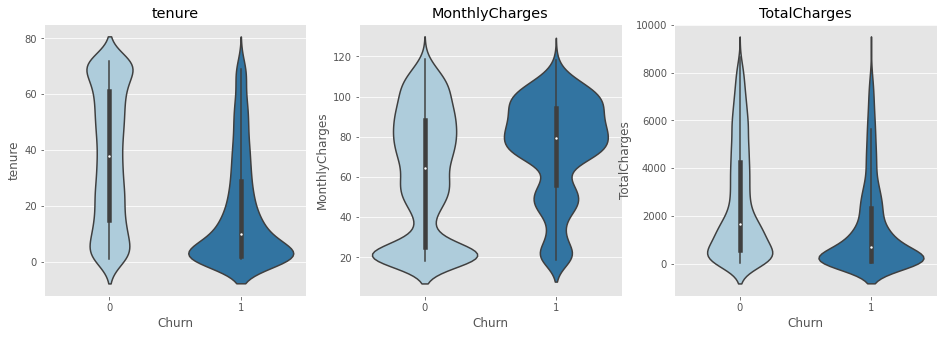

In [13]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (16,5))

for i in range(len(cols)):
    
    plt.subplot(1,3,i+1)
    
    sns.violinplot(x = Churn_Df['Churn'], y = Churn_Df.loc[:,cols[i]], palette = 'Paired')

    plt.title(cols[i])
    
plt.show()

**Findings**

* Customers who decide to leave, do so in the first months 
* Customers that stay display a uniform distribution regarding their tenure
* Churn is higher among customers with high monthly charges

## Data Processing

- At first we will convert categorical variables to binary using a label encoder

In [14]:
#copy of the dataset
Churn_Df_Tr = Churn_Df.copy(deep = True)

# label encoder
lbe = LabelEncoder()

# find categorical feautures
categorical = [col for col in Churn_Df.columns if col not in 
                ['customerID', 'Churn', 'MonthlyCharges', 'TotalCharges', 'tenure']]

# conversion
for cat in categorical:
    Churn_Df_Tr[cat] = lbe.fit_transform(Churn_Df_Tr[cat])
    
Churn_Df_Tr.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


#### *Correlation plot with regards to churn*

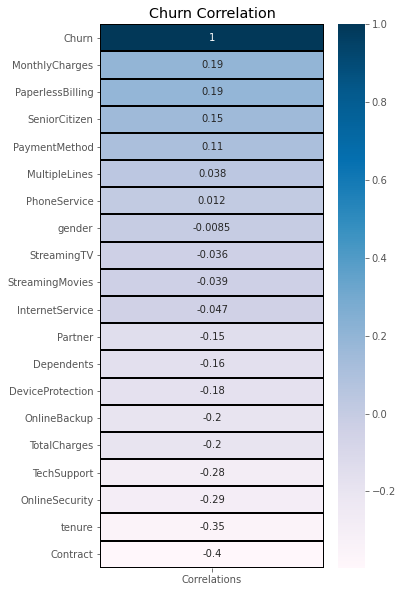

In [15]:
corr = Churn_Df_Tr.corrwith(Churn_Df_Tr['Churn']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,10))
sns.heatmap(corr,annot = True,linewidths = 0.4,linecolor = 'black', cmap = 'PuBu');
plt.title('Churn Correlation');

- We can see that the following attributes has a very low correlation value, so we decide to drop them
    - MultipleLines
    - PhoneService
    - Gender
    - StreamingTV
    - StreamingMovies
    - InternetService

In [16]:
Churn_Df_Tr.drop(columns = ['PhoneService', 'gender','StreamingTV','StreamingMovies','MultipleLines','InternetService']
              , axis = 1, inplace = True)

#### *One-Hot Encoding*

In [17]:
# create dummy variables for the categorical attributes with more than two unique values
Churn_Df_Tr = pd.get_dummies(Churn_Df_Tr, columns= [col for col in Churn_Df_Tr.columns if 10 >= Churn_Df_Tr[col].nunique() > 2]
                          , drop_first=True)

# drop customerID column
Churn_Df_Tr.drop('customerID', axis = 1, inplace = True)

Churn_Df_Tr.head()

,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,OnlineSecurity_1,OnlineSecurity_2,...,OnlineBackup_2,DeviceProtection_1,DeviceProtection_2,TechSupport_1,TechSupport_2,Contract_1,Contract_2,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3
0,0,1,0,1,1,29.85,29.85,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,34,0,56.95,1889.50,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2,0,0,0,2,1,53.85,108.15,1,0,1,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,45,0,42.30,1840.75,0,0,1,...,0,0,1,0,1,1,0,0,0,0
4,0,0,0,2,1,70.70,151.65,1,0,0,...,0,0,0,0,0,0,0,0,1,0


### *Train Test Split*

In [18]:
# define x, y
x = Churn_Df_Tr.drop(columns='Churn')
y = Churn_Df_Tr.Churn

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

## Feature Engineering

### *Feature Transformation*

- Feature transformation involves applying a mathematical formula to a specific column for mathematical modification.
- In our scenario, we will use the box-cox transformation on the **TotalCharges** column.
- This choice is motivated by the column's current high variance, which could potentially impact the accuracy of our analysis and predictions.

In [19]:
# transform using box-cox
x_train['TotalCharges'], best_lambda = boxcox(x_train['TotalCharges'], lmbda=None)
x_test['TotalCharges'] = boxcox(x_test['TotalCharges'], lmbda=best_lambda)

### *Feature Scaling*

- Certain machine learning algorithms may face challenges when dealing with data that has a widely varying range of values.
- *Feature Scaling* is employed to normalize the range of independent variables in the dataset.
- While most features in our dataset are already normalized, any that are not will require scaling to ensure uniformity in their ranges.

In [20]:
# get the features that need scaling
to_scale = [feature for feature in x_train.columns if (Churn_Df_Tr[feature].max() > 1)]

# features to scale
print(f'Features to scale: {to_scale}')

Features to scale: ['tenure', 'MonthlyCharges', 'TotalCharges']


- Having acquired the features, the next step involves determining the most suitable technique for scaling them.
- To make an informed decision, it's crucial to examine the distributions of these features.
- Depending on whether the distributions align with a normal distribution or not, we will opt for the scaler that best fits the scenario.

##### *Function to test for normality*

In [21]:
def analyze_distribution(column_data):
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(column_data, kde=True)
    plt.title('Distribution Plot')
    plt.show()

    # Perform Shapiro-Wilk test for normality
    stat, p_value = shapiro(column_data)

    # Display the test results
    print(f"Shapiro-Wilk Test for Normality:")
    print(f"Statistic: {stat}")
    print(f"P-value: {p_value}")

    # Interpret the results
    alpha = 0.05
    if p_value > alpha:
        print("The data appears to be normally distributed (fail to reject H0)")
    else:
        print("The data does not appear to be normally distributed (reject H0)")

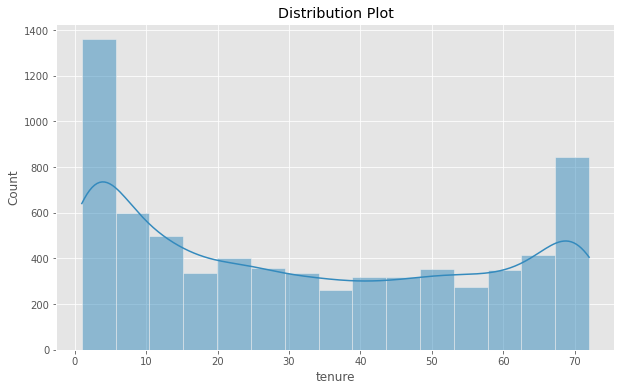

Shapiro-Wilk Test for Normality:
Statistic: 0.9037960171699524
P-value: 0.0
The data does not appear to be normally distributed (reject H0)


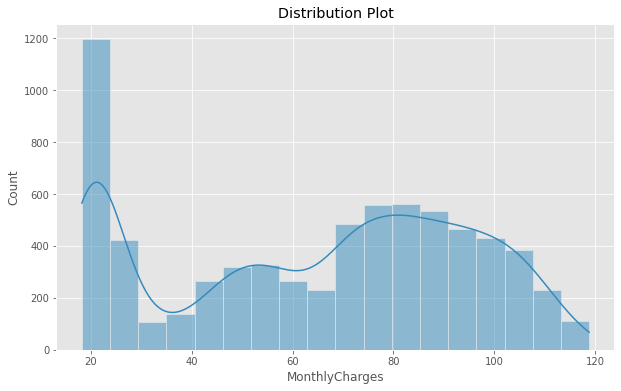

Shapiro-Wilk Test for Normality:
Statistic: 0.9209239482879639
P-value: 0.0
The data does not appear to be normally distributed (reject H0)


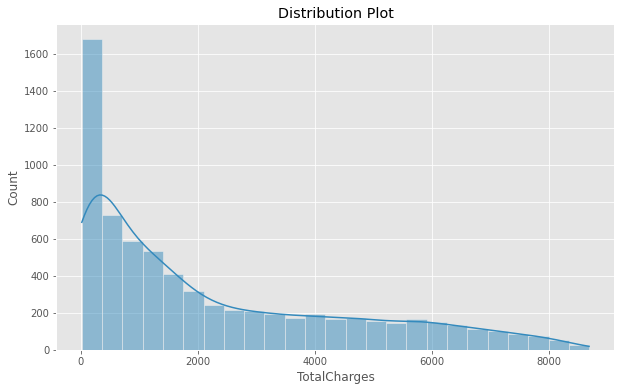

Shapiro-Wilk Test for Normality:
Statistic: 0.8604329228401184
P-value: 0.0
The data does not appear to be normally distributed (reject H0)


In [22]:
# execute for tenure
_ = analyze_distribution(Churn_Df_Tr['tenure'])

# execute for MonthlyCharges
_ = analyze_distribution(Churn_Df_Tr['MonthlyCharges'])

# execute for TotalCharges
_ = analyze_distribution(Churn_Df_Tr['TotalCharges'])

- Based on the visualizations, none of the features exhibits a normal distribution.
- Additionally, the Shapiro-Wilk test reveals that the *p-value* is below 5%, suggesting that none of the tested samples adheres to a normal distribution.
- Consequently, we **reject** the null hypothesis.
- In light of the test outcomes, these features will be scaled using `MinMaxScaler`.

##### *Scale*

In [23]:
# initialise scaler
mms = MinMaxScaler()

# scale train and test data
x_train[to_scale] = mms.fit_transform(x_train[to_scale])
x_test[to_scale] = mms.transform(x_test[to_scale])

### *Class Imbalance* 

- Recognizing the high imbalance in our dataset,
- To address this, we opt to cluster the overrepresented class.

***Methodology***

- Let N denote the count of samples in the minority class.
- The plan is to cluster the majority class into N clusters.
- Subsequently, we identify the centroids of each cluster, employing them as the training data for the overrepresented class.
- This approach ensures class balance.
- Additionally, using centroids enhances the representativeness of the training data for the overrepresented class.
- However, it's important to note that the dataset will be reduced in size as a trade-off.

In [24]:
y_train.value_counts()

0    4130
1    1495
Name: Churn, dtype: int64

##### *Cluster the abundant class*

In [25]:
def centroid_balancing(x_train: pd.DataFrame, y_train: pd.Series) -> tuple:
    """
    Balances the majority class by clustering it into N clusters (N being the minority class size),
    using centroids as training data for the majority class.
    
    Parameters:
    -----------
    x_train : pd.DataFrame
        The dataframe containing the training instances.
    y_train : pd.Series
        The series containing the respective training labels.

    Returns:
    --------
    x_train_balanced : pd.DataFrame
        The dataframe containing the cluster centroids as training instances.
    y_train_balanced : pd.Series
        The series containing the respective training labels.
    clusters : np.array
        The clusters created from the majority class.
    """
    
    # Identify the two classes and their frequencies
    class1, value1 = y_train.value_counts().index[0], y_train.value_counts()[0]
    class2, value2 = y_train.value_counts().index[1], y_train.value_counts()[1]
    
    # Determine the minority and majority class based on their frequencies
    minority_class, minority_value = (class1, value1) if value1 < value2 else (class2, value2)
    majority_class, majority_value = (class2, value2) if value1 < value2 else (class1, value1)
    
    # Extract records of the minority class
    x_train_min = x_train[y_train == minority_class]
    y_train_min = y_train[y_train == minority_class]
    
    # Extract records of the majority class
    x_train_maj = x_train[y_train == majority_class]
    y_train_maj = y_train[y_train == majority_class]
    
    # Initialize a clustering instance with the number of clusters equal to the minority class size
    model = AgglomerativeClustering(n_clusters=minority_value, linkage='ward')
    
    # Fit the clustering instance to the majority class and assign each record a cluster label
    clusters = model.fit_predict(x_train_maj)
    
    # Get the centroid of each cluster
    clf = NearestCentroid()
    clf.fit(x_train_maj, clusters)
    centroids = clf.centroids_
    
    # Create a dataframe with the centroids
    df_centroids = pd.DataFrame(columns=x_train.columns, data=centroids)
    
    # Concatenate records from the minority class with the centroids
    x_train_balanced = pd.concat([x_train_min, df_centroids])
    
    # Create a series containing the label of the majority class repeated as many times as the minority class size
    y_train_maj_values_to_append = pd.Series([majority_class] * minority_value)
    
    # Concatenate the labels of both the minority and majority class
    y_train_balanced = pd.concat([y_train_min, y_train_maj_values_to_append])
    
    return x_train_balanced, y_train_balanced, clusters

In [26]:
# execute balancing function
xbal_train, ybal_train, _ = centroid_balancing(x_train, y_train)

In [27]:
ybal_train.value_counts()

1    1495
0    1495
dtype: int64

## Classification Models

##### *Function for model cross validation*

In [28]:
def models_cv(x_train:pd.DataFrame,
                          y_train:pd.Series,
                          models:list):
    
    # create a dataframe to store the results
    index = [model[0] for model in models]
    columns = ['Precision', 'Recall', 'F1 Score', 'AUC', 'Accuracy']
    cv_scores = pd.DataFrame(data=np.nan, index=index, columns=columns)
    
    # create a StratifiedKFold instance
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # loop through classifiers
    for name, model in models:

        # cross validate
        scoring = ['precision', 'recall', 'f1', 'roc_auc', 'accuracy']
        scores = cross_validate(model, x_train, y_train, scoring=scoring, cv=cv, error_score='raise')

        # evaluate
        avg_precision = scores['test_precision'].mean()
        avg_recall = scores['test_recall'].mean()
        avg_f1 = scores['test_f1'].mean()
        avg_roc = scores['test_roc_auc'].mean()
        avg_accuracy = scores['test_accuracy'].mean()
        
        # store results
        cv_scores.loc[name, 'Precision'] = avg_precision
        cv_scores.loc[name, 'Recall'] = avg_recall
        cv_scores.loc[name, 'F1 Score'] = avg_f1
        cv_scores.loc[name, 'AUC'] = avg_roc
        cv_scores.loc[name, 'Accuracy'] = avg_accuracy

    return cv_scores

##### *Cross validate the classifiers*

In [29]:
models = [['DecisionTree', DecisionTreeClassifier(random_state=123)],
          ['BaggingClassifier', BaggingClassifier(DecisionTreeClassifier(),random_state=123)],
          ['RandomForestClassifier', RandomForestClassifier(random_state=123)],
          ['AdaBoostClassifier', AdaBoostClassifier(random_state=123)],
          ['LightGBM', LGBMClassifier(random_state=123)]]

In [30]:
# set starting time
start_time = datetime.now()

# execute custom cross validation function
scores = models_cv(xbal_train, ybal_train, models)

# set ending time
end_time = datetime.now()

print(f'Elapsed time: {end_time - start_time}')

Elapsed time: 0:00:03.044891


In [31]:
print(scores.sort_values(by='F1 Score', ascending=False))

                        Precision    Recall  F1 Score       AUC  Accuracy
AdaBoostClassifier       0.793242  0.802007  0.797452  0.879553  0.796321
LightGBM                 0.799341  0.790635  0.794914  0.884905  0.795987
RandomForestClassifier   0.785277  0.765217  0.774998  0.867863  0.777926
BaggingClassifier        0.799202  0.736455  0.766464  0.855939  0.775585
DecisionTree             0.716531  0.755184  0.735199  0.728094  0.728094


### *Grid Search* 

##### *Define hyperparameter grid for fine tuning*

In [32]:
# list of hyperparameters
h_grid = [['AdaBoostClassifier', {'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)],
                                      'n_estimators': range(100,600,100),
                                      'learning_rate': np.arange(0.1,0.4,0.1),
                                      'algorithm': ['SAMME', 'SAMME.R']}],
              ['LightGBM', {'num_iterations': range(100,600,100),
                            'learning_rate': np.arange(0.1,0.4,0.1),
                            'subsample': np.arange(0.6,1,0.1),
                            'subsample_freq': range(10,50,10),
                            'colsample_bytree': np.arange(0.4,1,0.1)}]]

##### *Define fine tuning function*

In [33]:
def gs_fine_tuning(x_train:pd.DataFrame,
                            y_train:pd.Series,
                            models:list,
                            param_grid:list,
                            scoring:str='f1'):
    
    # create a dataframe to store the results
    index = [model[0] for model in models]
    columns = [scoring]
    gs_scores = pd.DataFrame(data=np.nan, index=index, columns=columns)
    
    # create a StratifiedKFold instance
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # loop through classifiers
    for index, model in enumerate(models):
        
        # gridsearchCV
        grid = GridSearchCV(model[1], param_grid[index][1], scoring=scoring, cv=cv, n_jobs = -1)
        grid.fit(x_train, y_train)
        
        # evaluate
        best_score = grid.best_score_
        best_estimator = grid.best_estimator_
        
        # print results
        print('='*120)
        print(f'{index+1}. {model[0]}')
        print('-'*120)
        print(f'Best grid score: {best_score}')
        print(f'Best estimator: {best_estimator}', end='\n\n')
        
        # store results
        gs_scores.loc[model[0], scoring] = best_score

    return gs_scores

In [56]:
# set starting time
start_time = datetime.now()

# execute custom grid search function
gs_scores = grid_search_tune_models(xbal_train, ybal_train, models[-2:], h_grid, scoring='f1')

# set ending time
end_time = datetime.now()

print(f'Elapsed time: {end_time - start_time}')

1. AdaBoostClassifier
------------------------------------------------------------------------------------------------------------------------
Best grid score: 0.8063029429109367
Best estimator: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1, n_estimators=100, random_state=123)

2. LightGBM
------------------------------------------------------------------------------------------------------------------------
Best grid score: 0.8069469055307465
Best estimator: LGBMClassifier(colsample_bytree=0.4, num_iterations=100, random_state=123,
               subsample=0.8999999999999999, subsample_freq=10)

Elapsed time: 0:07:44.069248


### *Predictions (on test set)*

##### *Function for predictions*

In [34]:
def model_predictions(x_train:pd.DataFrame,
                     x_test:pd.DataFrame,
                     y_train:pd.Series,
                     y_test:pd.Series,
                     models:list):
    
    # create a dataframe to store the results
    index=[model[0] for model in models]
    columns=['Precision', 'Recall', 'F1 Score', 'AUC', 'Accuracy']
    prediction_scores = pd.DataFrame(np.nan, index=index, columns=columns)
    
    # loop through classifiers
    for i, (name, model) in enumerate(models):
        
        # fit and predict
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        
        # evaluate
        preds = model.predict(x_test)
        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        auc = roc_auc_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        
        cm = confusion_matrix(y_test, preds)
        counts = [value for value in cm.flatten()]
        percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(counts,percentages)]
        labels = np.asarray(labels).reshape(2,2)
        
        # print results
        print('='*120)
        print(f'{i+1}. {name}')
        print('-'*120)
        print(f'Precision: {precision}')
        print(f'Recall:    {recall}')
        print(f'F1 Score:  {f1}')
        print(f'AUC:       {auc}')
        print(f'Accuracy:  {accuracy}')
        print('-'*120)
        
        plt.figure(figsize=(8,6))
        ax = sns.heatmap(cm, annot=labels, cmap='Blues',fmt='')

        ax.set_title('Confusion Matrix \n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');

        ax.xaxis.set_ticklabels(['False','True'])
        ax.yaxis.set_ticklabels(['False','True'])

        plt.show()
        
        # store results
        prediction_scores.loc[name, 'Precision'] = precision
        prediction_scores.loc[name, 'Recall'] = recall
        prediction_scores.loc[name, 'F1 Score'] = f1
        prediction_scores.loc[name, 'AUC'] = auc
        prediction_scores.loc[name, 'Accuracy'] = accuracy

    return prediction_scores

In [35]:
# list of tuned classifiers
tuned_models = [
             ['AdaBoostClassifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1, n_estimators=100,random_state=123)],
             ['LightGBM', LGBMClassifier(colsample_bytree=0.4, subsample=0.89, subsample_freq=10, num_iterations=100, random_state=123)]
             ]

1. AdaBoostClassifier
------------------------------------------------------------------------------------------------------------------------
Precision: 0.48925619834710743
Recall:    0.7914438502673797
F1 Score:  0.6046986721144025
AUC:       0.746157549528656
Accuracy:  0.7249466950959488
------------------------------------------------------------------------------------------------------------------------


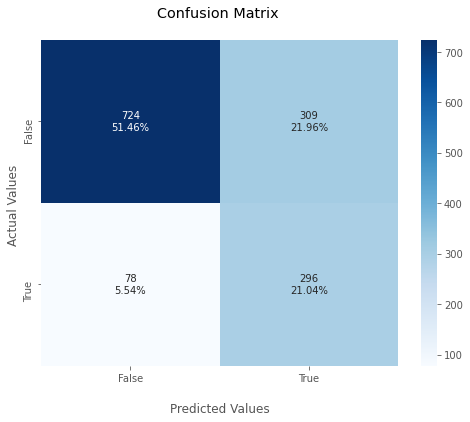

2. LightGBM
------------------------------------------------------------------------------------------------------------------------
Precision: 0.48366013071895425
Recall:    0.7914438502673797
F1 Score:  0.6004056795131846
AUC:       0.7427693597900306
Accuracy:  0.7199715707178393
------------------------------------------------------------------------------------------------------------------------


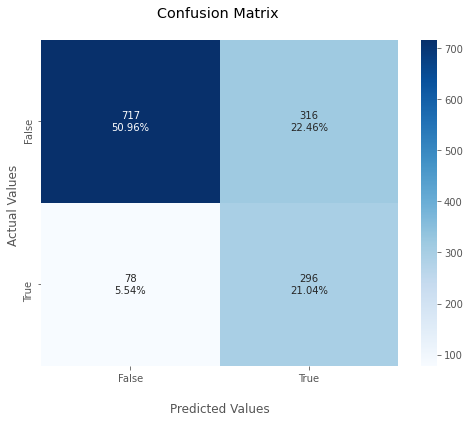

In [36]:
predictions = model_predictions(xbal_train, x_test, ybal_train, y_test, tuned_models)